# Workflow
-----------------------------
1. Read image.
2. Read label given in the model.
3. Read Model weights.
4. Read Model configuration.
5. Resize image to reduce number of pixels keeping aspect ratio.
6. Convert it to blob (required for input to the model).
7. Set blob as input to the model.
8. Predict from model using tuple unpacking in variables box and mask(here we dont need mask) using net.forward().
9. Put box on image
10. Resize the detected image to its original dimension(if you want)
---------------------------------
- We are assumning image contain only one person for now
- Mask are not perfect, we need to perform erosion or watershed algorithm on ROI

#### https://www.learnopencv.com/deep-learning-based-object-detection-and-instance-segmentation-using-mask-r-cnn-in-opencv-python-c/

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def imshow(img):
    plt.imshow(img, cmap='gray')

In [3]:
img = cv2.imread(r'billgates.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

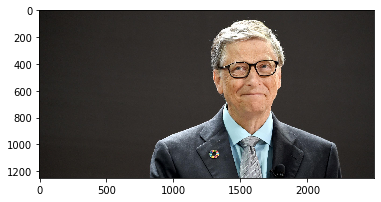

In [4]:
imshow(img)

In [5]:
labelpath = r'E:\dev\to_be_uploaded\opencv-instance-segmentation\mask-rcnn-coco\object_detection_classes_coco.txt'
with open(labelpath, 'r') as f:
    label = f.read().strip().split('\n')

In [6]:
configpath = r'E:\dev\to_be_uploaded\opencv-instance-segmentation\mask-rcnn-coco\mask_rcnn_inception_v2_coco_2018_01_28.pbtxt'
weightpath = r'E:\dev\to_be_uploaded\opencv-instance-segmentation\mask-rcnn-coco\frozen_inference_graph.pb'

In [7]:
# loding model
net = cv2.dnn.readNetFromTensorflow(weightpath, configpath)

Choice of Interpolation Method for Resizing
-----------------------------------------------------------------------------------
1. cv2.INTER_AREA: This is used when we need need to shrink an image.
2. cv2.INTER_CUBIC: This is slow but more efficient.
3. cv2.INTER_LINEAR: This is primarily used when zooming is required. This is the default interpolation technique.
--------------------------------------------------------------------------------------

In [8]:
# Resizing by maintaing the aspect raio

def resize(image, width=None, height=None):
    (h, w) = image.shape[:2]
    
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_LINEAR)
    
    return resized

In [9]:
resized_image = 300

In [10]:
img = resize(img, width=resized_image)

In [13]:
img.shape[:2]

(150, 300)

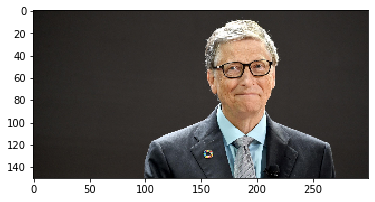

In [738]:
imshow(img)

https://stackoverflow.com/questions/37689423/convert-between-nhwc-and-nchw-in-tensorflow

In [739]:
# Blobs are the type of inputs for model and it returns a 4-D matrix with NCHW dimensions order. 
# N - Number of image in the batch
# C - Channel
# H - Height of image
# W - Width of image
blob = cv2.dnn.blobFromImage(img, swapRB=False, crop=False)

In [740]:
blob.shape

(1, 3, 150, 300)

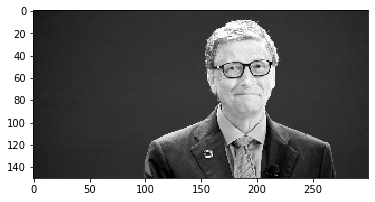

In [741]:
imshow(blob[0, 0, :, :]) # Red channel

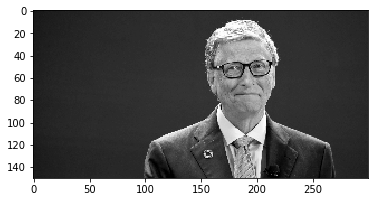

In [742]:
imshow(blob[0, 1, :, :]) # Blue channel

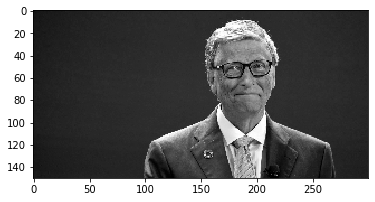

In [743]:
imshow(blob[0, 2, :, :]) # Green Channel

In [744]:
net.setInput(blob) # Setting input for the model

The blob is then passed in to the network as its input and a forward pass is run to get a list of predicted bounding boxes and the object masks from the output layers named as ‘detection_out_final‘ and ‘detection_masks‘ in the network.

box cordinates = left, top, right and bottom locations of the bounding box of the detected object in the frame

the top scoring 100 detection boxes are processed by the mask prediction branch. So, with 100 ROIs and 90 object classes, the mask prediction part of the network outputs a 4D tensor of size 100x90x15x15, where each mask is of size 15×15.

In [810]:
# Box is a 4 dimension matrix having - 
# [NotKnown, thisframe, NumberOfDetectionMade, [classID, class score, probability, x_cordOfBox,y_cordOfBox, heightOfBox, widthOfBox]]
# 4th dimension have 7 dimension written above and you can also call "probability" as 'confidence'
# https://www.youtube.com/watch?v=MIfPu4RxfLw

# What is NumberOfDetectionMade? - Top 100 box

box, mask = net.forward(["detection_out_final","detection_masks"])

In [811]:
box.shape

(1, 1, 100, 7)

In [812]:
mask.shape

(100, 90, 15, 15)

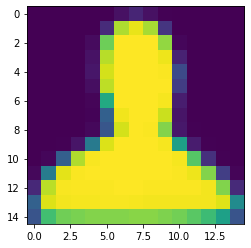

In [813]:
plt.imshow(mask[0,0,:,:])

In [814]:
for i, j in enumerate(label):
    print(i, j)

0 person
1 bicycle
2 car
3 motorcycle
4 airplane
5 bus
6 train
7 truck
8 boat
9 traffic light
10 fire hydrant
11 street sign
12 stop sign
13 parking meter
14 bench
15 bird
16 cat
17 dog
18 horse
19 sheep
20 cow
21 elephant
22 bear
23 zebra
24 giraffe
25 hat
26 backpack
27 umbrella
28 shoe
29 eye glasses
30 handbag
31 tie
32 suitcase
33 frisbee
34 skis
35 snowboard
36 sports ball
37 kite
38 baseball bat
39 baseball glove
40 skateboard
41 surfboard
42 tennis racket
43 bottle
44 plate
45 wine glass
46 cup
47 fork
48 knife
49 spoon
50 bowl
51 banana
52 apple
53 sandwich
54 orange
55 broccoli
56 carrot
57 hot dog
58 pizza
59 donut
60 cake
61 chair
62 couch
63 potted plant
64 bed
65 mirror
66 dining table
67 window
68 desk
69 toilet
70 door
71 tv
72 laptop
73 mouse
74 remote
75 keyboard
76 cell phone
77 microwave
78 oven
79 toaster
80 sink
81 refrigerator
82 blender
83 book
84 clock
85 vase
86 scissors
87 teddy bear
88 hair drier
89 toothbrush


In [815]:
H = img.shape[0]
W = img.shape[1]
img.shape

(150, 300, 3)

In [816]:
# we need to scale our box relative to size of image

left, top, right, bottom = box[0, 0, 0, 3:7]*(W, H, W, H)
box[0, 0, 0, 3:7]

# 0 - Not Known     
# 0  - This image   
# 0 - Person
# 3:7 - left, top, right and bottom locations of the bounding box

# Left or Right means width
# Top or Bottom means height

array([0.33608747, 0.07840818, 0.91582966, 1.        ], dtype=float32)

In [817]:
left, top, right, bottom = int(left), int(top), int(right), int(bottom)

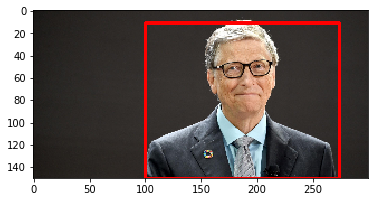

In [818]:
detected = cv2.rectangle(img=img.copy(), pt1=(left,top), pt2=(right, bottom), color=(255,0,0), thickness=2)
imshow(detected)

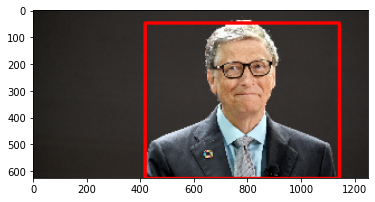

In [819]:
# Rescale image to original size

imshow(resize(detected, width=1250))

# Now using Mask

In [820]:
mask.shape
# N - Top scoring 100 detection boxes(100 ROI) 
# C - class of 90 objects 
# HxW - with mask size 15x15 (height x width)

(100, 90, 15, 15)

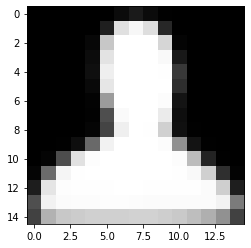

In [821]:
imshow(mask[0, 0,:, : ])

#### Resize the mask such that it's the same dimensions of the bounding box

We will not resize it by keeping the aspect ratio but according to the box because mask repersent each object in the image.

----

In [822]:
active = 1

----

In [866]:
if active:
    original_mask = mask.copy()
    active = 0
else:
    mask = original_mask.copy()

In [867]:
# Finding height and width of mask
box_width = right-left
box_height = bottom-top
# where left, right, top, bottom are the coordinates of the box
# box width and height should be positive

# Choice of Interpolation Method for Resizing –

1. cv2.INTER_AREA: This is used when we need need to shrink an image.
2. cv2.INTER_CUBIC: This is slow but more efficient.
3. cv2.INTER_LINEAR: This is primarily used when zooming is required. This is the default interpolation technique.

In [868]:
mask.shape

(100, 90, 15, 15)

In [869]:
personID = 0
label[personID]

'person'

In [870]:
top_scoring_box = 0
# print(mask[top_scoring_box, personID])
mask = mask[top_scoring_box, personID]
# selecting person mask by assuming highest probability is of person

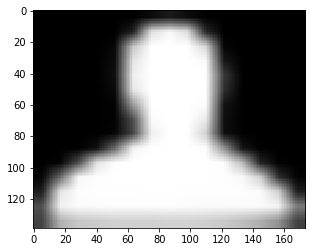

In [871]:
# order of new dimension is (width, height)
mask = cv2.resize(mask, (box_width, box_height))
imshow(cv2.resize(mask, (box_width, box_height)))

In [872]:
# Our minimum threshold for the pixel-wise mask segmentation
minimum_threshold = 0.4  #50%

# print(mask>minimum_threshold)

mask = mask>minimum_threshold

In [873]:
mask.shape

(139, 174)

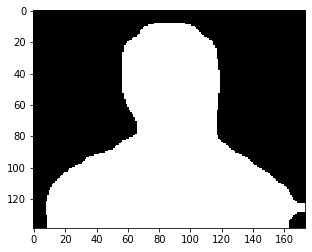

In [874]:
imshow(mask)

In [875]:
mask.dtype

dtype('bool')

In [876]:
mask = mask.astype(np.uint8) # as we need to convert boolean mask to 8-bit values to operate. 
# This 8-bit comes from documentation of cv2.bitwise_and

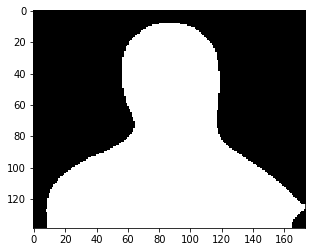

In [877]:
# we apply blur on mask so that it we can remove hard edges from the mask
mask = cv2.GaussianBlur(mask, (35,35), 0)
imshow(mask)

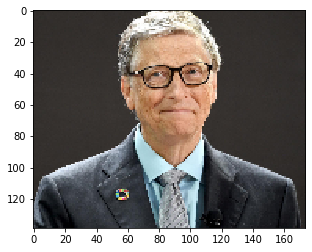

In [878]:
imshow(img[top:bottom, left:right])

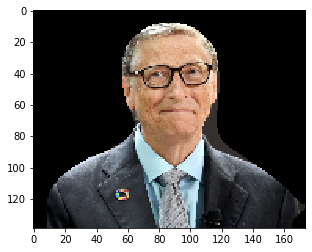

In [879]:
# TO mask the image we need to implement bitwise and operation
roi = cv2.bitwise_and(img[top:bottom, left:right],img[top:bottom, left:right],mask=mask)
imshow(roi)

In [880]:
img.shape

(150, 300, 3)

In [881]:
roi.shape

(139, 174, 3)

In [882]:
output = img.copy()

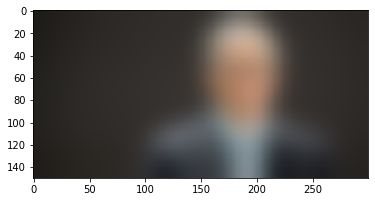

In [883]:
kernel = (71, 71)
op = cv2.GaussianBlur(output, kernel, 0)
imshow(op)

# How to put ROI on output
1. create a black background of shape of op
2. we will attach roi to that background
3. perform addWeighted operation with new roi and op to create a blended image

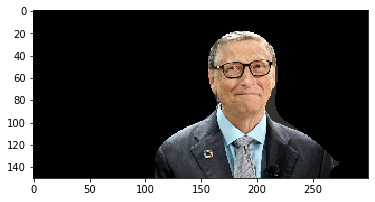

In [884]:
background = np.full(op.shape, 0, dtype=np.uint8)
background[top:bottom, left:right] = roi
ROI = background.copy()
imshow(background)

In [885]:
op.shape

(150, 300, 3)

In [886]:
ROI.shape

(150, 300, 3)

In [887]:
# To perform bitwise operation we need to have same dimension and same datatype of source 1 and 2

In [888]:
ROI.dtype

dtype('uint8')

In [889]:
op.dtype

dtype('uint8')

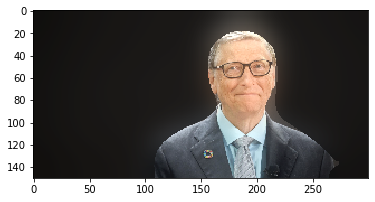

In [890]:
final_image = cv2.addWeighted(op,0.5, ROI, 0.7, 1)
imshow(final_image)